In [178]:
#Data Analysis and Visualisation
import numpy as np 
import pandas as pd 
import seaborn as sns
import sklearn
import matplotlib as mlt 
import matplotlib.pyplot as plt
import os
import missingno

#Data Preprossesing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,StandardScaler

#Machine Learning 
import catboost
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score

#ignoring the warnings
import warnings
warnings.filterwarnings('ignore')

import math, time, random, datetime

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


In [179]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
sample_data=pd.read_csv("/kaggle/input/titanic/gender_submission.csv")

In [180]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [181]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


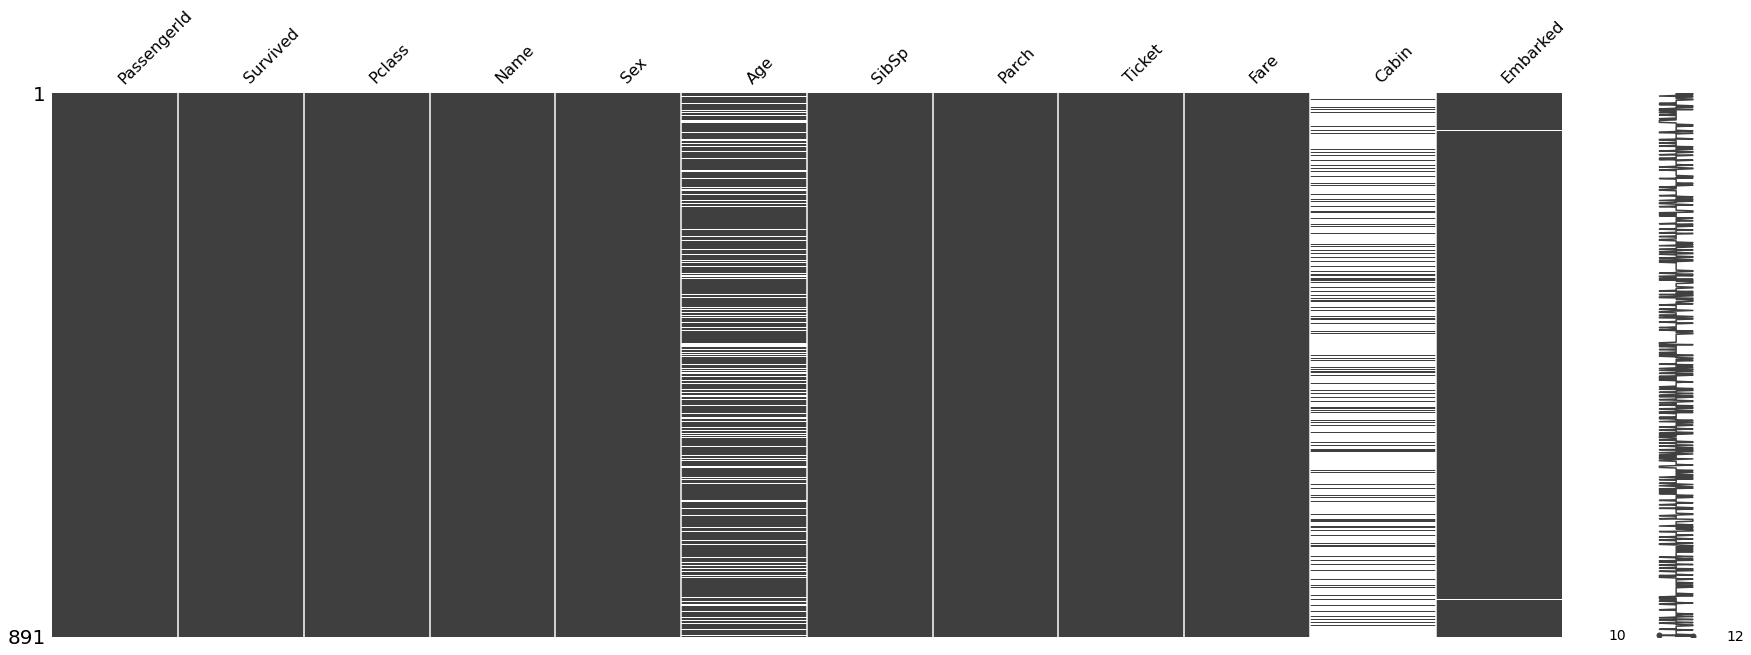

In [182]:
missingno.matrix(train_data, figsize = (30,10))

In [183]:
train_data.Embarked[train_data.Embarked.isnull()==True]=list(train_data['Embarked'].mode())[0]
train_data['Embarked'][train_data.Embarked.isnull()==True]

Series([], Name: Embarked, dtype: object)

In [184]:
train=train_data.drop(['Survived'], axis=1)
combined = train.append(test_data)
combined.reset_index(drop=True, inplace=True)

In [185]:
combined.Cabin.fillna('U', inplace=True)

In [186]:
cabin = set()

for c in combined['Cabin']:
    try:
        cabin.add(c[0])
    except:
        cabin.add('U')
print(cabin)

{'D', 'C', 'E', 'B', 'G', 'T', 'U', 'A', 'F'}


In [187]:
combined['Cabin'] = combined['Cabin'].map(lambda c: c[0])

In [188]:
combined.Fare.fillna(combined.Fare.mean(), inplace=True)

In [189]:
title=[]
for i in combined.Name:
    title.append(i.split(',')[1].split('.')[0].strip())
combined['Title']=title

In [190]:
combined.Title.replace(['Dona','Mrs'], inplace=True)

In [191]:
grouped_train = combined.groupby(['Sex','Pclass','Title'])
grouped_median_train = grouped_train.median()
grouped_median_train = grouped_median_train.reset_index()[['Sex', 'Pclass', 'Title', 'Age']]
grouped_median_train['Age'].fillna(grouped_median_train['Age'].mean(), inplace=True)
grouped_median_train.head()

,Sex,Pclass,Title,Age
0,female,1,Don,33.208333
1,female,1,Dr,49.000000
2,female,1,Lady,48.000000
3,female,1,Master,48.000000
4,female,1,Miss,32.000000


In [192]:
def fill_age(row):
    condition = (
        (grouped_median_train['Sex'] == row['Sex']) & 
        (grouped_median_train['Title'] == row['Title']) & 
        (grouped_median_train['Pclass'] == row['Pclass'])
    ) 
    return grouped_median_train[condition]['Age'].values[0]


def process_age():
    global combined
    # a function that fills the missing values of the Age variable
    combined['Age'] = combined.apply(lambda row: fill_age(row) if np.isnan(row['Age']) else row['Age'], axis=1)
    return combined

combined = process_age()

In [193]:
combined.reset_index(drop=True, inplace=True)

In [194]:
combined.drop(['PassengerId','Name','Ticket'], axis=1, inplace=True)

## Creating new features

In [195]:
combined['Relative']=combined['SibSp']+combined['Parch']

In [196]:
combined['Age_pClass']= combined['Age']* combined['Pclass']

In [197]:
combined['Fare_Per_Person'] = combined['Fare']/(combined['Relative']+1)

In [198]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Pclass           1309 non-null   int64  
 1   Sex              1309 non-null   object 
 2   Age              1309 non-null   float64
 3   SibSp            1309 non-null   int64  
 4   Parch            1309 non-null   int64  
 5   Fare             1309 non-null   float64
 6   Cabin            1309 non-null   object 
 7   Embarked         1309 non-null   object 
 8   Title            1309 non-null   object 
 9   Relative         1309 non-null   int64  
 10  Age_pClass       1309 non-null   float64
 11  Fare_Per_Person  1309 non-null   float64
dtypes: float64(4), int64(4), object(4)
memory usage: 122.8+ KB


In [199]:
columns=['Pclass'+'.'+str(i) for i in sorted(combined['Pclass'].unique())]
new_ohe_df = pd.get_dummies(combined['Pclass'])
new_ohe_df.columns=columns

In [200]:
ohe=OneHotEncoder(sparse=False)

In [201]:
other_cols=['Sex', 'SibSp', 'Parch', 'Cabin', 'Embarked', 'Title', 'Relative']

In [202]:
for column in other_cols:
    columns=[column+'.'+str(i) for i in sorted(combined[column].unique())]
    dumm = pd.get_dummies(combined[column])
    dumm.columns=columns
    new_ohe_df=new_ohe_df.join(dumm)
    print(new_ohe_df)

      Pclass.1  Pclass.2  Pclass.3  Sex.female  Sex.male
0            0         0         1           0         1
1            1         0         0           1         0
2            0         0         1           1         0
3            1         0         0           1         0
4            0         0         1           0         1
...        ...       ...       ...         ...       ...
1304         0         0         1           0         1
1305         1         0         0           1         0
1306         0         0         1           0         1
1307         0         0         1           0         1
1308         0         0         1           0         1

[1309 rows x 5 columns]
      Pclass.1  Pclass.2  Pclass.3  Sex.female  Sex.male  SibSp.0  SibSp.1  \
0            0         0         1           0         1        0        1   
1            1         0         0           1         0        0        1   
2            0         0         1           1         0 

In [203]:
dumm

,Relative.0,Relative.1,Relative.2,Relative.3,Relative.4,Relative.5,Relative.6,Relative.7,Relative.10
0,0,1,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
1304,1,0,0,0,0,0,0,0,0
1305,1,0,0,0,0,0,0,0,0
1306,1,0,0,0,0,0,0,0,0
1307,1,0,0,0,0,0,0,0,0


In [204]:
new_ohe_df[['Age','Fare', 'Fare_Per_Person', 'Age_pClass']]=StandardScaler().fit_transform(combined[['Age','Fare', 'Fare_Per_Person', 'Age_pClass']])

In [205]:
new_ohe_df

,Pclass.1,Pclass.2,Pclass.3,Sex.female,Sex.male,SibSp.0,SibSp.1,SibSp.2,SibSp.3,SibSp.4,...,Relative.3,Relative.4,Relative.5,Relative.6,Relative.7,Relative.10,Age,Fare,Fare_Per_Person,Age_pClass
0,0,0,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,-0.542811,-0.503595,-0.472827,0.127311
1,1,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0.650146,0.734503,0.422775,-0.793843
2,0,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,-0.244572,-0.490544,-0.352543,0.522092
3,1,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0.426466,0.382925,0.168454,-0.892538
4,0,0,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0.426466,-0.488127,-0.349047,1.410348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,0,0,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,-0.244572,-0.488127,-0.349047,0.522092
1305,1,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0.724705,1.461829,2.472032,-0.760945
1306,0,0,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0.687425,-0.503595,-0.371425,1.755781
1307,0,0,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,-0.244572,-0.488127,-0.349047,0.522092


In [206]:
ohe_train=new_ohe_df[:891]
ohe_test=new_ohe_df[891:]

In [207]:
ohe_train

,Pclass.1,Pclass.2,Pclass.3,Sex.female,Sex.male,SibSp.0,SibSp.1,SibSp.2,SibSp.3,SibSp.4,...,Relative.3,Relative.4,Relative.5,Relative.6,Relative.7,Relative.10,Age,Fare,Fare_Per_Person,Age_pClass
0,0,0,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,-0.542811,-0.503595,-0.472827,0.127311
1,1,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0.650146,0.734503,0.422775,-0.793843
2,0,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,-0.244572,-0.490544,-0.352543,0.522092
3,1,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0.426466,0.382925,0.168454,-0.892538
4,0,0,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0.426466,-0.488127,-0.349047,1.410348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,1,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,-0.170012,-0.392417,-0.210580,-0.267469
887,1,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,-0.766490,-0.063719,0.264961,-1.418912
888,0,0,1,1,0,0,1,0,0,0,...,1,0,0,0,0,0,-0.766490,-0.190364,-0.410238,-0.168774
889,1,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,-0.244572,-0.063719,0.264961,-1.188623


In [208]:
X_train=ohe_train
y_train = train_data["Survived"]
X_test =ohe_test

In [209]:
X_train

,Pclass.1,Pclass.2,Pclass.3,Sex.female,Sex.male,SibSp.0,SibSp.1,SibSp.2,SibSp.3,SibSp.4,...,Relative.3,Relative.4,Relative.5,Relative.6,Relative.7,Relative.10,Age,Fare,Fare_Per_Person,Age_pClass
0,0,0,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,-0.542811,-0.503595,-0.472827,0.127311
1,1,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0.650146,0.734503,0.422775,-0.793843
2,0,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,-0.244572,-0.490544,-0.352543,0.522092
3,1,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0.426466,0.382925,0.168454,-0.892538
4,0,0,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0.426466,-0.488127,-0.349047,1.410348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,1,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,-0.170012,-0.392417,-0.210580,-0.267469
887,1,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,-0.766490,-0.063719,0.264961,-1.418912
888,0,0,1,1,0,0,1,0,0,0,...,1,0,0,0,0,0,-0.766490,-0.190364,-0.410238,-0.168774
889,1,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,-0.244572,-0.063719,0.264961,-1.188623


In [210]:
X_test

,Pclass.1,Pclass.2,Pclass.3,Sex.female,Sex.male,SibSp.0,SibSp.1,SibSp.2,SibSp.3,SibSp.4,...,Relative.3,Relative.4,Relative.5,Relative.6,Relative.7,Relative.10,Age,Fare,Fare_Per_Person,Age_pClass
891,0,0,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0.389186,-0.492396,-0.355223,1.361000
892,0,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,1.321184,-0.508429,-0.476324,2.594689
893,0,1,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,2.439580,-0.456465,-0.303241,2.035417
894,0,0,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,-0.170012,-0.476284,-0.331913,0.620787
895,0,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,-0.542811,-0.406194,-0.459657,0.127311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,0,0,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,-0.244572,-0.488127,-0.349047,0.522092
1305,1,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0.724705,1.461829,2.472032,-0.760945
1306,0,0,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0.687425,-0.503595,-0.371425,1.755781
1307,0,0,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,-0.244572,-0.488127,-0.349047,0.522092


# ML Algos

In [211]:
def fit_ml_algo(algo, X_train, y_train, cv):
    
    # One Pass
    model = algo.fit(X_train, y_train)
    acc = round(model.score(X_train, y_train) * 100, 2)
    
    
    # Cross Validation 
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    # Cross-validation accuracy metric
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    
    return train_pred, acc, acc_cv

In [212]:

# Logistic Regression
start_time = time.time()
train_pred_log, acc_log, acc_cv_log = fit_ml_algo(LogisticRegression(), 
                                                               X_train, 
                                                               y_train, 
                                                                    10)
log_time = (time.time() - start_time)
print("Accuracy: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

Accuracy: 84.29
Accuracy CV 10-Fold: 82.83
Running Time: 0:00:02.856210


In [213]:
# Random Forest Classifier
start_time = time.time()
train_pred_rfc, acc_rfc, acc_cv_rfc = fit_ml_algo(RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1), 
                                                   X_train, y_train, 10)
rfc_time = (time.time() - start_time)
print("Accuracy: %s" % acc_rfc)
print("Accuracy CV 10-Fold: %s" % acc_cv_rfc)
print("Running Time: %s" % datetime.timedelta(seconds=rfc_time))

Accuracy: 86.31
Accuracy CV 10-Fold: 83.61
Running Time: 0:00:01.528234


In [214]:
# k-Nearest Neighbours
start_time = time.time()
train_pred_knn, acc_knn, acc_cv_knn = fit_ml_algo(KNeighborsClassifier(), 
                                                  X_train, 
                                                  y_train, 
                                                  10)
knn_time = (time.time() - start_time)
print("Accuracy: %s" % acc_knn)
print("Accuracy CV 10-Fold: %s" % acc_cv_knn)
print("Running Time: %s" % datetime.timedelta(seconds=knn_time))

Accuracy: 86.42
Accuracy CV 10-Fold: 80.47
Running Time: 0:00:00.235381


In [215]:

# Gaussian Naive Bayes
start_time = time.time()
train_pred_gaussian, acc_gaussian, acc_cv_gaussian = fit_ml_algo(GaussianNB(), 
                                                                      X_train, 
                                                                      y_train, 
                                                                           10)
gaussian_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gaussian)
print("Accuracy CV 10-Fold: %s" % acc_cv_gaussian)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Accuracy: 49.16
Accuracy CV 10-Fold: 51.74
Running Time: 0:00:00.085585


In [216]:
# Linear SVC
start_time = time.time()
train_pred_svc, acc_linear_svc, acc_cv_linear_svc = fit_ml_algo(LinearSVC(),
                                                                X_train, 
                                                                y_train, 
                                                                10)
linear_svc_time = (time.time() - start_time)
print("Accuracy: %s" % acc_linear_svc)
print("Accuracy CV 10-Fold: %s" % acc_cv_linear_svc)
print("Running Time: %s" % datetime.timedelta(seconds=linear_svc_time))

Accuracy: 83.95
Accuracy CV 10-Fold: 82.49
Running Time: 0:00:00.412783


In [217]:
# Stochastic Gradient Descent
start_time = time.time()
train_pred_sgd, acc_sgd, acc_cv_sgd = fit_ml_algo(SGDClassifier(), 
                                                  X_train, 
                                                  y_train,
                                                  10)
sgd_time = (time.time() - start_time)
print("Accuracy: %s" % acc_sgd)
print("Accuracy CV 10-Fold: %s" % acc_cv_sgd)
print("Running Time: %s" % datetime.timedelta(seconds=sgd_time))

Accuracy: 69.36
Accuracy CV 10-Fold: 78.23
Running Time: 0:00:00.150879


In [218]:
# Decision Tree Classifier
start_time = time.time()
train_pred_dt, acc_dt, acc_cv_dt = fit_ml_algo(DecisionTreeClassifier(), 
                                                                X_train, 
                                                                y_train,
                                                                10)
dt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_dt)
print("Accuracy CV 10-Fold: %s" % acc_cv_dt)
print("Running Time: %s" % datetime.timedelta(seconds=dt_time))

Accuracy: 98.65
Accuracy CV 10-Fold: 79.69
Running Time: 0:00:00.101712


In [219]:
# Gradient Boosting Trees
start_time = time.time()
train_pred_gbt, acc_gbt, acc_cv_gbt = fit_ml_algo(GradientBoostingClassifier(), 
                                                                       X_train, 
                                                                       y_train,
                                                                       10)
gbt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gbt)
print("Accuracy CV 10-Fold: %s" % acc_cv_gbt)
print("Running Time: %s" % datetime.timedelta(seconds=gbt_time))

Accuracy: 90.8
Accuracy CV 10-Fold: 82.49
Running Time: 0:00:01.518659


In [220]:
# Neural Networks
start_time = time.time()
clf = MLPClassifier(activation='tanh',
                    hidden_layer_sizes=(5, 5), random_state=3, max_iter=1000, warm_start=True)

train_pred_nn, acc_nn, acc_cv_nn = fit_ml_algo(clf, X_train, y_train, 10)
nn_time = (time.time() - start_time)
print("Accuracy: %s" % acc_nn)
print("Accuracy CV 10-Fold: %s" % acc_cv_nn)
print("Running Time: %s" % datetime.timedelta(seconds=nn_time))

Accuracy: 88.1
Accuracy CV 10-Fold: 83.16
Running Time: 0:00:09.947942


In [221]:


# perceptron
start_time = time.time()
perceptron = Perceptron(max_iter=5)
train_pred_pt, acc_pt, acc_cv_pt = fit_ml_algo(perceptron, X_train, y_train, 10)
pt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_pt)
print("Accuracy CV 10-Fold: %s" % acc_cv_pt)
print("Running Time: %s" % datetime.timedelta(seconds=pt_time))

Accuracy: 80.47
Accuracy CV 10-Fold: 76.32
Running Time: 0:00:00.101982


In [222]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes', 'Random Forest Classifier',
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees','NN', 'Perceptron'],
    'Score': [
        acc_knn, 
        acc_log,  
        acc_gaussian, 
        acc_rfc,
        acc_sgd, 
        acc_linear_svc, 
        acc_dt,
        acc_gbt,
        acc_nn,
        acc_pt
    ]})
print("---Reuglar Accuracy Scores---")
models.sort_values(by='Score', ascending=False)

---Reuglar Accuracy Scores---


,Model,Score
6,Decision Tree,98.65
7,Gradient Boosting Trees,90.80
8,NN,88.10
0,KNN,86.42
3,Random Forest Classifier,86.31
1,Logistic Regression,84.29
5,Linear SVC,83.95
9,Perceptron,80.47
4,Stochastic Gradient Decent,69.36
2,Naive Bayes,49.16


In [223]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes', 'Random Forest Classifier',
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees','NN', 'Perceptron'],
    'Score': [
        acc_cv_knn, 
        acc_cv_log,  
        acc_cv_gaussian, 
        acc_cv_rfc,
        acc_cv_sgd, 
        acc_cv_linear_svc, 
        acc_cv_dt,
        acc_cv_gbt,
        acc_cv_nn,
        acc_cv_pt
    ]})
print("---Reuglar Accuracy Scores---")
models.sort_values(by='Score', ascending=False)

---Reuglar Accuracy Scores---


,Model,Score
3,Random Forest Classifier,83.61
8,NN,83.16
1,Logistic Regression,82.83
5,Linear SVC,82.49
7,Gradient Boosting Trees,82.49
0,KNN,80.47
6,Decision Tree,79.69
4,Stochastic Gradient Decent,78.23
9,Perceptron,76.32
2,Naive Bayes,51.74


In [224]:
'''random_forest = RandomForestClassifier(n_estimators=100, random_state=1, oob_score = True)
random_forest.fit(X_train, y_train)
Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, y_train)

acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)
print(round(acc_random_forest,2,), "%")'''

'random_forest = RandomForestClassifier(n_estimators=100, random_state=1, oob_score = True)\nrandom_forest.fit(X_train, y_train)\nY_prediction = random_forest.predict(X_test)\n\nrandom_forest.score(X_train, y_train)\n\nacc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)\nprint(round(acc_random_forest,2,), "%")'

In [225]:
'''print("oob score:", round(random_forest.oob_score_, 4)*100, "%")'''

'print("oob score:", round(random_forest.oob_score_, 4)*100, "%")'

In [226]:
'''param_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [1, 5, 10, 25, 50, 70], "min_samples_split" : [2, 4, 10 ,12, 16, 18, 25, 35]}
from sklearn.model_selection import GridSearchCV, cross_val_score
rf = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1, n_jobs=-1)
clf = GridSearchCV(estimator=rf, param_grid=param_grid, n_jobs=-1)'''

'param_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [1, 5, 10, 25, 50, 70], "min_samples_split" : [2, 4, 10 ,12, 16, 18, 25, 35]}\nfrom sklearn.model_selection import GridSearchCV, cross_val_score\nrf = RandomForestClassifier(n_estimators=100, max_features=\'auto\', oob_score=True, random_state=1, n_jobs=-1)\nclf = GridSearchCV(estimator=rf, param_grid=param_grid, n_jobs=-1)'

In [227]:
'''clf.fit(X_train, y_train)'''

'clf.fit(X_train, y_train)'

In [228]:
'''clf.best_params_'''

'clf.best_params_'

In [229]:
'''random_forest = RandomForestClassifier(criterion = "gini", 
                                       min_samples_leaf = 1, 
                                       min_samples_split = 12,   
                                       n_estimators=100, 
                                       max_features='auto', 
                                       oob_score=True, 
                                       random_state=1, 
                                       n_jobs=-1)

random_forest.fit(X_train, y_train)
Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, y_train)

print("oob score:", round(random_forest.oob_score_, 4)*100, "%")'''

'random_forest = RandomForestClassifier(criterion = "gini", \n                                       min_samples_leaf = 1, \n                                       min_samples_split = 12,   \n                                       n_estimators=100, \n                                       max_features=\'auto\', \n                                       oob_score=True, \n                                       random_state=1, \n                                       n_jobs=-1)\n\nrandom_forest.fit(X_train, y_train)\nY_prediction = random_forest.predict(X_test)\n\nrandom_forest.score(X_train, y_train)\n\nprint("oob score:", round(random_forest.oob_score_, 4)*100, "%")'

In [230]:
param_grid = { "activation" : ['tanh', 'relu'],'hidden_layer_sizes':[(4,5), (5,5), (6,6)]   ,  "alpha" : [0.0001, 0.001, 0.01, 0.1], "max_iter" : [100, 200, 400, 800]}
from sklearn.model_selection import GridSearchCV, cross_val_score 

In [231]:
nn = MLPClassifier(random_state=3, warm_start=True)
clf = GridSearchCV(estimator=nn, param_grid=param_grid)

In [232]:
clf.fit(X_train, y_train)

GridSearchCV(estimator=MLPClassifier(hidden_layer_sizes=(5, 5), random_state=3,
                                     warm_start=True),
             n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.001, 0.01, 0.1],
                         'hidden_layer_sizes': [(4, 5), (5, 5), (6, 6)],
                         'max_iter': [100, 200, 400, 800]})

In [233]:
clf.best_params_

{'activation': 'tanh',
 'alpha': 0.01,
 'hidden_layer_sizes': (6, 6),
 'max_iter': 800}

In [236]:
nn = MLPClassifier(activation = "tanh", 
                                       hidden_layer_sizes = (6,6), 
                                       alpha = 0.01,   
                                       max_iter=800, 
                                       random_state=3,warm_start=True)

nn.fit(X_train, y_train)
Y_prediction = nn.predict(X_test)

nn.score(X_train, y_train)

0.9102132435465768

In [237]:
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': Y_prediction})

In [238]:
output.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [239]:
output['Survived'] = output['Survived'].astype(int)
output.to_csv('my_submission.csv', index=False)

In [240]:
submissions_check = pd.read_csv("my_submission.csv")
submissions_check.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
